In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from input_data import lb3_time_opticaldensity_ph_glucose_protein_35

In [2]:
init = {
    "X": lb3_time_opticaldensity_ph_glucose_protein_35["OpticalDensity"].iloc[0],
    "pH": lb3_time_opticaldensity_ph_glucose_protein_35["pH"].iloc[0],
    "G": lb3_time_opticaldensity_ph_glucose_protein_35["Glucose"].iloc[0],
    "B": lb3_time_opticaldensity_ph_glucose_protein_35["Protein"].iloc[0]
}

initial_params = {
    'beta': [0.6, 0.3, 0.05, 0.02],
    'gamma': [0.3, 0.8, 0.4],
    'delta': [0.5],
    'eta': [0.3, 0.1]
}

In [3]:
# Для простоти зовнішні впливи (Temperature, Stirring, Aeration) поки не включаємо
timesteps = len(lb3_time_opticaldensity_ph_glucose_protein_35)
results = {'X': [init['X']], 'pH': [init['pH']], 'Glucose': [init['G']], 'Protein': [init['B']]}

for t in range(timesteps - 1):
    X_t, pH_t, G_t, B_t = results['X'][-1], results['pH'][-1], results['Glucose'][-1], results['Protein'][-1]
    X_next = (
        initial_params['beta'][0] *
        X_t + initial_params['beta'][1] *
        pH_t + initial_params['beta'][2] *
        G_t + initial_params['beta'][3] *
        B_t
    )
    pH_next = initial_params['gamma'][0] + initial_params['gamma'][1] * pH_t - initial_params['gamma'][2] * X_t
    G_next = G_t - initial_params['delta'][0] * X_t
    B_next = B_t + initial_params['eta'][0] * X_t - initial_params['eta'][1] * B_t

    results['X'].append(X_next)
    results['pH'].append(pH_next)
    results['Glucose'].append(G_next)
    results['Protein'].append(B_next)

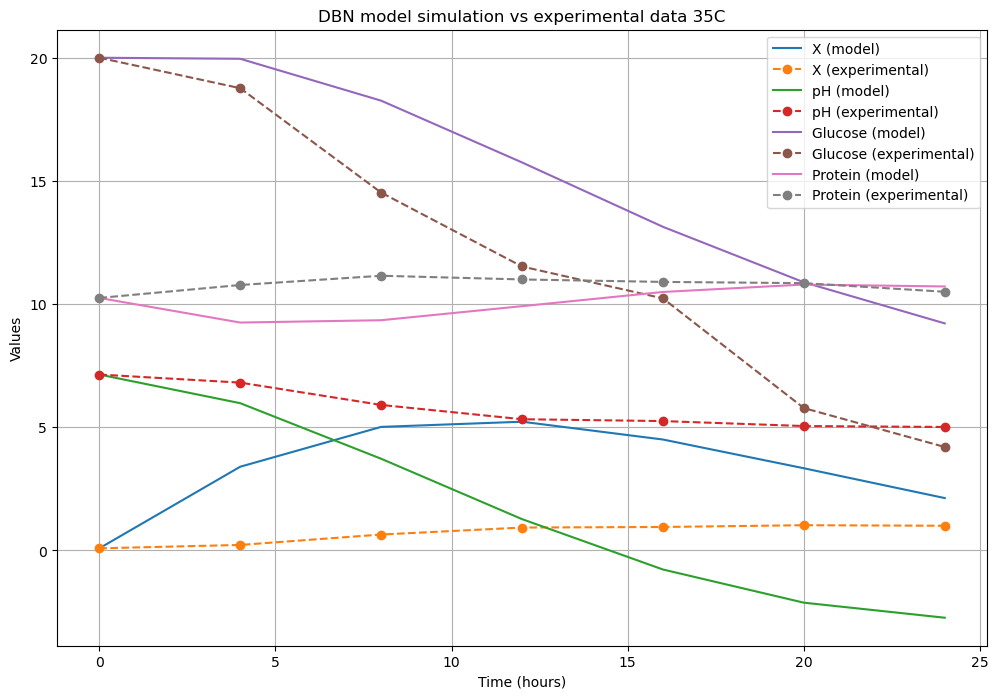

In [6]:
plt.figure(figsize=(12, 8))
for key in results:
    plt.plot(lb3_time_opticaldensity_ph_glucose_protein_35["Time"], results[key], label=key + ' (model)')
    plt.plot(
        lb3_time_opticaldensity_ph_glucose_protein_35["Time"],
        lb3_time_opticaldensity_ph_glucose_protein_35[key if key != 'X' else 'OpticalDensity'],
        'o--',
        label=key + ' (experimental)'
    )

plt.xlabel('Time (hours)')
plt.ylabel('Values')
plt.legend()
plt.title('DBN model simulation vs experimental data 35C')
plt.grid()
plt.show()

## Optimization part

In [27]:
def simulate(params, temperature: float = 1.0) -> tuple[np.ndarray, ...]:
    Xs, pHs, Gs, Bs = (
        [lb3_time_opticaldensity_ph_glucose_protein_35["OpticalDensity"].iloc[0]],
        [lb3_time_opticaldensity_ph_glucose_protein_35["pH"].iloc[0]],
        [lb3_time_opticaldensity_ph_glucose_protein_35["Glucose"].iloc[0]],
        [lb3_time_opticaldensity_ph_glucose_protein_35["Protein"].iloc[0]]
    )
    timestamps = len(lb3_time_opticaldensity_ph_glucose_protein_35) - 1

    for _ in range(timestamps):
        X, pH, G, B = Xs[-1], pHs[-1], Gs[-1], Bs[-1]

        # Apply temperature multiplier to the rate-like X_next equation
        X_next = (params[0] * X + params[1] * pH + params[2] * G + params[3] * B) * temperature
       
        pH_next = params[4] + params[5] * pH - params[6] * X
        G_next = G - params[7] * X
        B_next = B + params[8] * X - params[9] * B
        
        Xs.append(X_next)
        pHs.append(pH_next)
        Gs.append(G_next)
        Bs.append(B_next)
    return np.array(Xs), np.array(pHs), np.array(Gs), np.array(Bs)


def loss(params):
    """
    Стандартизувати залишки для кожного ряду (вирівнює масштаби між X, pH, G, B)
    """
    X_pred, pH_pred, G_pred, B_pred = simulate(params)

    X_obs = lb3_time_opticaldensity_ph_glucose_protein_35["OpticalDensity"].values
    pH_obs = lb3_time_opticaldensity_ph_glucose_protein_35["pH"].values
    G_obs = lb3_time_opticaldensity_ph_glucose_protein_35["Glucose"].values
    B_obs = lb3_time_opticaldensity_ph_glucose_protein_35["Protein"].values

    # Safe std helper
    _std = lambda a: float(np.std(a)) if float(np.std(a)) > 0 else 1.0
    std_X, std_pH, std_G, std_B = map(_std, (X_obs, pH_obs, G_obs, B_obs))

    # Standardized residuals
    rX = (X_pred - X_obs) / std_X
    rpH = (pH_pred - pH_obs) / std_pH
    rG = (G_pred - G_obs) / std_G
    rB = (B_pred - B_obs) / std_B

    err = np.sum(rX**2) + np.sum(rpH**2) + np.sum(rG**2) + np.sum(rB**2)
    print(f'{err=}')
    return float(err)


params = np.array([0.6, 0.3, 0.05, 0.02, 0.01, 0.01, 0.01, 0.3, 0.8, 0.4])
res = minimize(loss, params, method='L-BFGS-B', options={'maxiter': 10000})
print('Optimal params:', res.x)

err=2161.724479484181
err=2161.7244548839353
err=2161.724454135849
err=2161.7242646231343
err=2161.7243954252253
err=2161.724476169564
err=2161.7244711830363
err=2161.7244864796203
err=2161.724480317912
err=2161.7244462790404
err=2161.724576207091
err=1193579.8967777789
err=1193579.9242121407
err=1193579.8996539612
err=1193579.911240963
err=1193579.9296888448
err=1193579.8970758826
err=1193579.8977066402
err=1193579.8907360141
err=1193579.8753232337
err=1193579.9279381877
err=1193579.8542459554
err=5959.41014714439
err=5959.410396195838
err=5959.410203586496
err=5959.410806360204
err=5959.410560309594
err=5959.410155595985
err=5959.410166572139
err=5959.410101303234
err=5959.410089468691
err=5959.410299121911
err=5959.40990390259
err=1527.751321043906
err=1527.7513283305307
err=1527.7513148383703
err=1527.7513283911435
err=1527.7513265078467
err=1527.7513204894167
err=1527.75131904631
err=1527.7513222929808
err=1527.7513186680308
err=1527.7513010896391
err=1527.7513751891497
err=1460.8

In [28]:
X_model_temp35, pH_model_temp35, G_model_temp35, B_model_temp35 = simulate(res.x, temperature=0.976458)

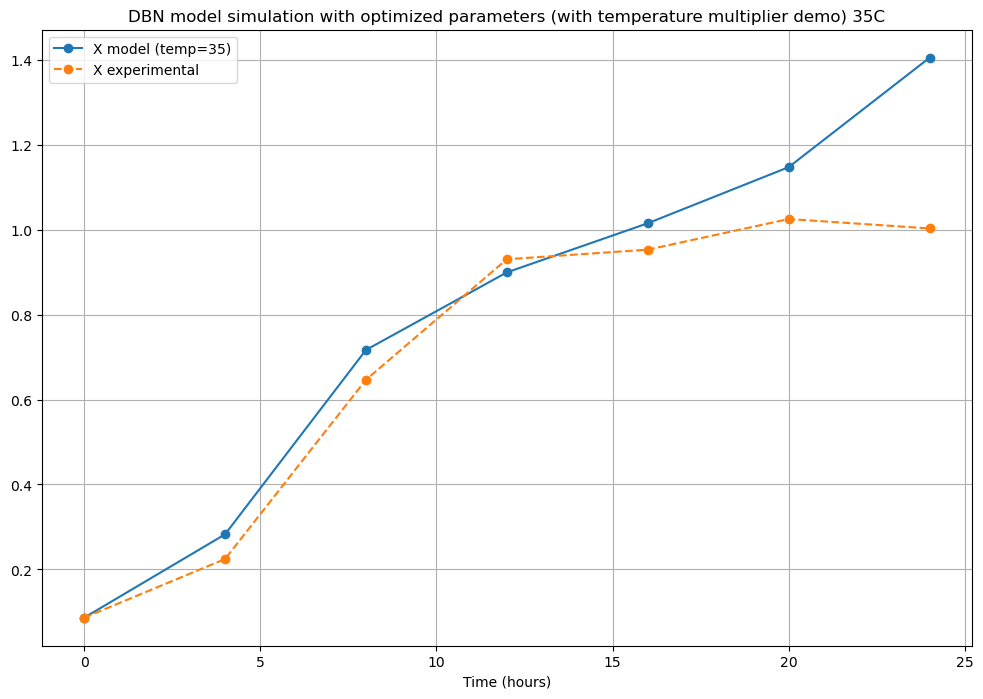

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(lb3_time_opticaldensity_ph_glucose_protein_35['Time'], X_model_temp35, label='X model (temp=35)', marker='o')
plt.plot(lb3_time_opticaldensity_ph_glucose_protein_35['Time'], lb3_time_opticaldensity_ph_glucose_protein_35['OpticalDensity'], 'o--', label='X experimental')

plt.legend()
plt.xlabel('Time (hours)')
plt.title('DBN model simulation with optimized parameters (with temperature multiplier demo) 35C')
plt.grid()
plt.show()